# Convolution Neural Networks

Let's begin by loading some of the tools we will need to this job. We will utilize Keras for building/training our neural network and matplotlib for plotting and visualization, and numpy for *everything* (period).

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

Using TensorFlow backend.


## The Data

Let's use one of the most common image data sets used to benchmark convolution network implementations: MNIST. We explored it some in other introductions, so I'll let is speak for itself this time around. Please see the Single- and Multi-layer tutorials before attempting this one...

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(60000, 28, 28)

(60000,)

(10000, 28, 28)

(10000,)

In [3]:
## Standardize the -input- data between 0.0-1.0 (real)
## instead of the default 0-255 (integer)
x_train = x_train.astype('float32').reshape(x_train.shape+(1,))
x_test = x_test.astype('float32').reshape(x_test.shape+(1,))
x_train /= 255
x_test /= 255

# Convert class vector [0-9] to categorical assignments (one-hot)
y_train = keras.utils.to_categorical(y_train, len(np.unique(y_train)))
y_test = keras.utils.to_categorical(y_test, len(np.unique(y_test)))

display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(60000, 28, 28, 1)

(60000, 10)

(10000, 28, 28, 1)

(10000, 10)

Remember that these are greyscale images, so there is just a single intensity value for each pixel. Full color images would need to have *3* channels (red, green, blue) for processing. Even though this is the case, Keras `Conv2D` layers expect that images have *three* dimensions (3D tensors) and so you must explicitly set this third dimension to 1 for it to accept each image as input. The `reshape()` function is used to add this extra dimension (wich a size of 1) to the existing data tensors.

In [4]:
model = keras.Sequential()
# Note the input size (there is only one channel - intensity)
# these images... if you are using color images, your would
# need to set the last dimension of the input_shape to -3-
# above and this would carry over into this cell...
model.add(keras.layers.Conv2D(64, kernel_size=(8, 8),
                              activation='relu',
                              input_shape=[x_train.shape[1],
                                           x_train.shape[2],
                                           x_train.shape[3]]))
model.add(keras.layers.Conv2D(128, (8, 8), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 21, 64)        4160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       524416    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

This is a pretty big network, no? Over 1 million connection weights! The convolution layers are applied twice over over the image before applying a pooling step, so the number of units *even after pooling* is quite large. Once flattened, this creates a large set of weights to the immediate dense layer which follows. The result is funneled into a smaller layer before using a softmax layer to categorize the image. 

## Counting Connection Weights...
Before moving on, let's unpack some of the output from the `summary()` function to understand what has happened here. There are a lot of weights, so it's worth thinking about what they are doing and where they came from.

First, the initial `Conv2D` layer has 4160 parameters (connection weights). We selected a layer size of `64` when making the layer, so we are create 64 different *feature detector* units which we will slide around (convolve with) the image in order to detect this feature anywhere in the image. Each unit gets its own bias weight, so there are 4096 weights left unaccounted for. Each feature detector was requested to make a `kernel_size` of 8 x 8 pixels (that's 64 weights for each unit) and so 64 x 64 = 4096. All weights for this layer are now accounted for. The same weights are used at each 8 x 8 patch in the image (overlapping and crossing) because we want each unit to become a dedicated *feature detector* during the learning process.

However, that also means there are 21 x 21 unique 8 x 8 patches within this image, so that each unit calculates an activation value for each of the 441 (21 x 21) locations, but these activation patterns stay arranged in a 21 x 21 grid just like a 2D image. This means that the output for this layer is 21 x 21 x 64 in size... getting big, right?

Now, for the second `Conv2D` layer, there are 524416 weights (WOW!). So, how do we account for all of those weights? Well, first we again start with the number of units requested, in this case 128. Each has a single bias weight, which leaves us with 524288 weights unaccounted for so far. There is again an 8 x 8 kernel requested at this layer, so each unit has a set of 64 weights assigned to it, but only within *one* of the 21 x 21 grids from the previous layer (and there are 64 of them). So, 64 (kernel weights) x 128 (units) x 64 (prev units) = 524288, and all weights are now accounted for. Finally, each of these 128 units is being slid across the 21 x 21 grid from the previous layer using the 8 x 8 kernel, and there are 14 x 14 =  196 unique patches. Again, the 14 x 14 arrangement of the activation outputs is maintained for each of the 128 units to retain 2D structure. However, we have now created a double convolution (complex features detected as convolutions of simpler features).

We follow up with a `MaxPooling2D` layer with a kernel size of 2 x 2. This means that we downsample the 14 x 14 grids from the previous layer with *nonoverlapping* patches of 2 x 2, and retain the maximum in this region (because it's most likely that only *one* complex feature will be detected in any of these distinct patches). This also helps with reducing the size of the activations from the previous layer by half from 14 x 14 x 128 down to 7 x 7 x 128. An additional `Dropout()` layer is also added here to encourage the network to be robust to missing features (maybe forcing different units in the convolutional layers to be somewhat redundant).

The `Flatten()` layer is designed to remove the 2D structure of the activation (layer output) vectors at this point. Since we have 7 x 7 x 128 = 6272, it just reshapes the output from the previous layer into the flattened 1D vector of activations. This allows us to stack standard `Dense` and `Dropout` layers from now, but the calculating the number of connection weights is now much easier. For example, after the `Flatten` layer, we have a layer of 128 units (`Dense`), so the weight matrix contains 6272 x 128 + 128 [bias weights] = 802944 connection weights total. After an additional `Dropout` layer, we have a `Dense` layer of 10 units (the output layer), so 128 x 10 + 10 [bias] = 1290 connection weights. Therefore, all parameters can be accounted for in the convolution and flattening process.

It's important to think through this exercise to understand how the network is wired up if you plan to use convolution nets on your particular problem...

## Training Time

OK, hold up just one second. One thing you need to understand is that this is a *big* network and there is *a lot* of data moving through it. It's not large compared to what some research groups train these days, but working on a powerful desktop (even Biosim) will still require a *several* minutes to train it up. If you complete this cycle of training, you can expect > 98% accuracy on the testing data at the end of the day.

In [5]:
batch_size = 512
epochs = 5
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 339s 7ms/step - loss: 0.3870 - acc: 0.8784 - val_loss: 0.0804 - val_acc: 0.9754
Epoch 2/5
48000/48000 [==============================] - 334s 7ms/step - loss: 0.1113 - acc: 0.9671 - val_loss: 0.0597 - val_acc: 0.9821
Epoch 3/5
48000/48000 [==============================] - 332s 7ms/step - loss: 0.0784 - acc: 0.9766 - val_loss: 0.0477 - val_acc: 0.9851
Epoch 4/5
48000/48000 [==============================] - 332s 7ms/step - loss: 0.0617 - acc: 0.9821 - val_loss: 0.0439 - val_acc: 0.9876
Epoch 5/5
48000/48000 [==============================] - 334s 7ms/step - loss: 0.0496 - acc: 0.9855 - val_loss: 0.0416 - val_acc: 0.9873


In [6]:
# Final Result - Generalization!
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 17s 2ms/step
Test loss: 0.0312782057868
Test accuracy: 0.9896


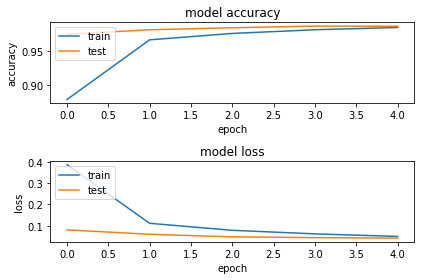

In [7]:
plt.figure(1)  
  
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()  

## Examining the Weights

Let's see if we can get a glimpse into what the network has learned by unpacking some of the weights in the network and plotting them. Since the kernel patches have a 2D structure to them, we would expect the network to start learning interesting 2D features which capture edges and common shapes in these small patches that can be stitched together to form composite digits. These features are what a convolution network is all about: changing the inductive bias of the network to better capture the kinds of features useful for classifying 2D/image data.

OK, so we can use the `get_weights()` function to grab them, and we expect 8 sets of them. This is because 4 layers in the network construction introduced connection weights (only four rows in the summary have a non-zero entry in #Params). Then, then connection weights and bias weights for each layer are divided into two separate tensors each. The connection weights will not be matrices since the addition of 2D structure rearranges them based on the selected kernel size.

Let's grab one set, and then many more...

In [8]:
# This is everything!
weights = model.get_weights()

In [9]:
# How many tensors?
len(weights)

8

In [10]:
# What's the shape of the tensor
# for the connection weights at
# the -first- Conv2D layer?
weights[0].shape

(8, 8, 1, 64)

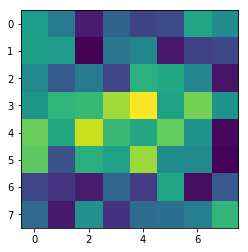

In [11]:
# We can plot the kernel weight matrix
# for just the first unit (out of 64)
# as an example...
plt.imshow(weights[0][:,:,0,0])
plt.show()

The light values indicate high weights, and the dark regions indicate low weights. In general, high weights cause a unit to turn on when pixel intensities are high and low weights cause a unit to turn off when pixel intensities are high. Therefore regions which transition from high to low weights are finding edges. Different units will detect different shape and orienations of these edge features, which form the basic building blocks for object detection and recognition. We can look at all 64 of the units by creating a plot with 64 small 8 x 8 subplots.

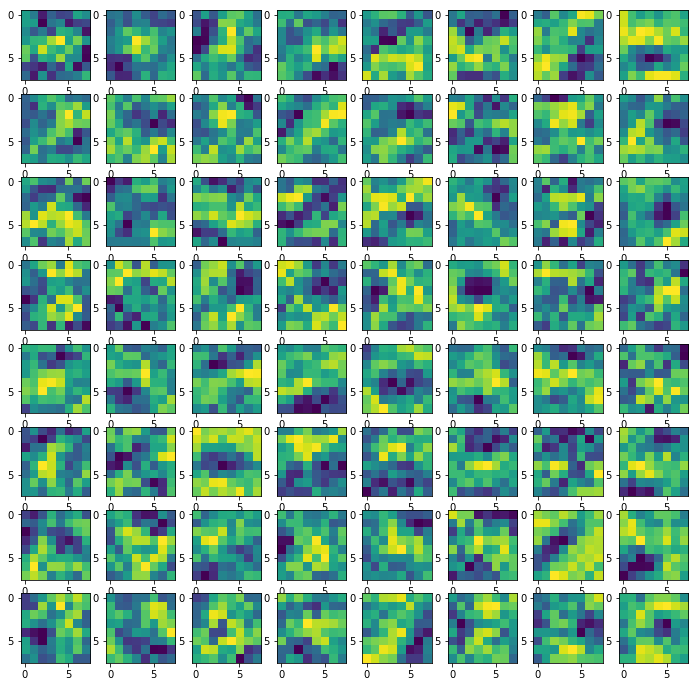

In [12]:
fig,axes = plt.subplots(8,8)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(8):
    for y in range(8):
        data = weights[0][:,:,:,(x*8)+y].reshape(8,8)
        
        axes[x,y].imshow(data)
plt.show()

These edge features are  then combined at the next `Conv2D` layer to form more complex features, so they are detecting changes in observed features. 

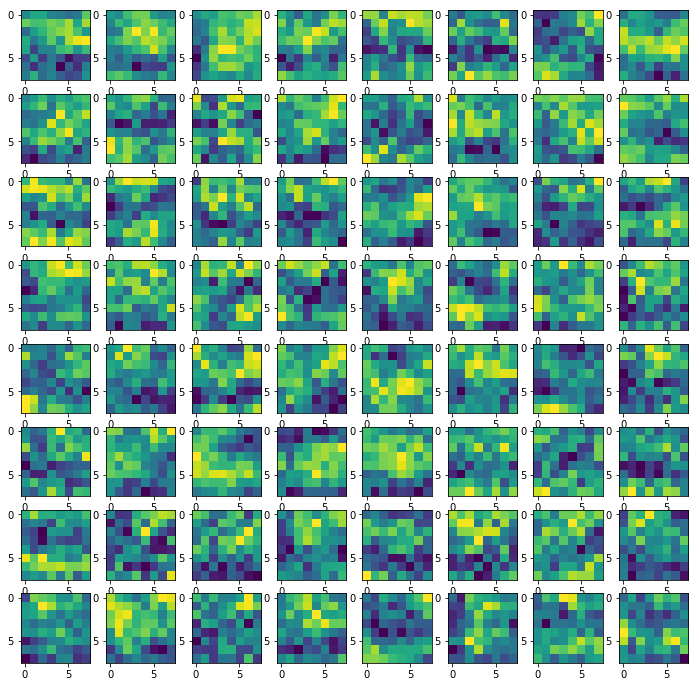

In [13]:
fig,axes = plt.subplots(8,8)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(8):
    for y in range(8):
        axes[x,y].imshow(weights[2][:,:,(x*8)+y,1].reshape(8,8))
plt.show()

We've now built and trained a basic convolution neural network, but there's more on this to come soon!